Universidad del valle de Guatemala 
Andres Quinto 
Andree Toledo 
Laboratorio 6 DS / Analisis de redes sociales

In [1]:
# #API Y TOKENS
API_KEY = "twEQRTK5ZKiol9uVpHdjzbOiY"
API_KEY_SECRET = "VB2zKLQGPsBRlQgMazxH3zZc1zSIanCadaJIlLMOhwsJsUMlPK"
ACC_TOKEN="712902088011874304-RoL1YIpnD1KKw3WQT0PHbRsSigAs6KM"
ACC_TOKEN_SECRET="atAOOsJ2dg26eo6AmzdEahF392pGuNSYdRTEmS3wbZthg"
TOKEN = "AAAAAAAAAAAAAAAAAAAAACjHhAEAAAAAXTh0XtmjnvybscEUdMbHmEVf%2Bh0%3DlEvp6WSu8ngO5aSqxI98QmLcRs6jviM3ZyloVqNJFKyMH9D7T0"


In [2]:
# #LIBRERIAS
import tweepy
import pandas as pd
import re
import string
import demoji
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import csv
import emoji

from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.util import ngrams

from collections import defaultdict
from collections import  Counter

from wordcloud import WordCloud

#sklearn
from sklearn.feature_extraction.text import CountVectorizer
from sklearn import feature_extraction, linear_model, model_selection, preprocessing
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer

In [3]:
#Se crea el archivo csv, si ya existe, se escribe en él.
file = open('tweets_trafico.csv', 'a')

writer = csv.writer(file)

#useful tutorial https://youtu.be/bNDRiaFyLrs
#oauth
auth = tweepy.OAuth1UserHandler(
    API_KEY, 
    API_KEY_SECRET, 
    ACC_TOKEN, 
    ACC_TOKEN_SECRET
)

api = tweepy.API(auth, wait_on_rate_limit=True)
#How to build a query on the api: https://developer.twitter.com/en/docs/twitter-api/tweets/search/integrate/build-a-query
search_query = "#traficogt OR #TránsitoSCP OR #traficoGT -is:retweets" #removimos a amilcar montejo por que muchos de sus tweets o menciones son acerca de otros temas y no de trafico

tweets = tweepy.Cursor(api.search_tweets,
            q=search_query,
            lang="es").items(500)


#lista
tweetss = []
for tweet in tweets:
    tweetss.append(tweet)
    temporal = tweet.text
    temporal = temporal.replace('á', 'a')
    temporal = temporal.replace('é', 'e')
    temporal = temporal.replace('í', 'i')
    temporal = temporal.replace('ó', 'o')
    temporal = temporal.replace('ú', 'u')
    temporal = temporal.replace('Á', 'A')
    temporal = temporal.replace('É', 'E')
    temporal = temporal.replace('Í', 'I')
    temporal = temporal.replace('Ó', 'O')
    temporal = temporal.replace('Ú', 'U')
    temporal = temporal.replace('ñ', 'n')
    temporal = temporal.replace('Ñ', 'N')
    temporal = temporal.replace('Ü', 'U')
    temporal = temporal.replace('ü', 'u')
    writer.writerow([tweet.created_at, temporal.encode('utf-8')])
    
print("Cantidad de Tweets extraidos:", len(tweetss))


Cantidad de Tweets extraidos: 500


In [4]:
#Dataframe build
#Creamos el data frame
tweets_df = pd.DataFrame()

for tweet in tweets:
    hashtags = []
    try:
        for hashtag in tweet.entities["hashtags"]:
            hashtags.append(hashtag["text"])
        text = api.get_status(id=tweet.id, tweet_mode='extended').full_text
    except:
        pass
    tweets_df = tweets_df.append(pd.DataFrame({'user_name': tweet.user.name, 
                                            'user_location': tweet.user.location,\
                                            'user_description': tweet.user.description,
                                            'user_verified': tweet.user.verified,
                                            'date': tweet.created_at,
                                            'text': text, 
                                            'hashtags': [hashtags if hashtags else None],
                                            'source': tweet.source}))
    tweets_df = tweets_df.reset_index(drop=True)

In [5]:
#Retiramos los emojis en los tweets con la extensión demoji
tweetsEmojiless = []
for tweet in tweetss:
    tweetsEmojiless.append(demoji.replace(tweet.text, repl=" "))

# colocamos todo en letras minusculas
for i in range(len(tweetsEmojiless)):
    tweetsEmojiless[i] = tweetsEmojiless[i].lower()



In [6]:
data = pd.read_csv('tweets_trafico.csv')
data.columns = ["Date", "Tweet"]
len(data.columns)

import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

stopwords = set(stopwords.words('spanish'))
expresiones = ["el",'los','las','la','de','que','porque','de','por','lo','brt','object','deic',
                'bxc2xa1ojala','Name','bel','lenght','viern','dtype', 'brt', 'rep', 'viniciogutierr3', 'radiopuntogt', 'b', 'rt', '|', 'conste', 'el', 'no', "b'rt", "length", "tweet", 'httpstcoktvdn3hrlo', 'axe2x80xa6', 'nnxc2xa', 'pue'
                ,'redes', 'vida', 'coronavirusgt', 'besto', 'regist']
for i in expresiones:
    stopwords.add(i)
print(stopwords)

{'mucho', 'conste', 'seremos', 'para', 'estuvimos', 'habéis', 'sobre', 'las', 'todo', 'hubieran', 'más', 'tengo', 'habrían', 'tuyo', 'hubieras', 'coronavirusgt', 'sentidos', 'habrás', 'hayamos', 'estás', 'habíais', 'sí', 'entre', 'hubiera', 'suyas', 'tendría', 'radiopuntogt', 'fuéramos', 'qué', 'tenga', 'tuyas', 'serás', 'rep', 'ni', 'hubierais', 'estar', 'un', 'estarías', 'os', 'hubo', 'tus', 'todos', 'por', 'seríais', "b'rt", 'b', 'bel', 'fuisteis', 'sentid', 'él', 'redes', 'cuando', 'bxc2xa1ojala', 'estada', 'están', 'algunos', 'otra', 'éramos', 'estuvisteis', 'ese', 'tuviese', 'pero', 'muy', 'tuve', 'otras', 'estaréis', 'durante', 'estuviéramos', 'tendríais', 'tendrías', 'teniendo', 'les', 'tendrás', 'seríamos', 'vuestros', 'eran', 'habida', 'estoy', 'soy', 'era', 'en', 'estemos', 'tened', 'algo', 'estuvieras', 'estuve', 'como', 'ya', 'estuviste', 'no', 'seáis', 'pue', 'httpstcoktvdn3hrlo', 'vuestra', 'tendré', 'hayas', 'habido', 'object', 'mías', 'también', 'habrías', 'tuviésemos'

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\aeqv2\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [7]:
def remove_characters(text):
    '''Remove all signs from a string'''
    return text.translate(text.maketrans('', '', string.punctuation))

def remove_url(text):
    '''Remove url from a string'''
    return re.sub(r'^https?:\/\/.*[\r\n]*', '', text, flags=re.MULTILINE)

def remove_num(text):
    '''Remove num'''
    return re.sub('^\d+\s|\s\d+\s|\s\d+$','',text)

In [8]:
# Se quitan vacíos
data = data.dropna(subset=['Tweet'])

# Lowercasing
data['Tweet'] = data['Tweet'].apply(lambda line: str(line).lower())

# Se quitan signos de puntuación
data['Tweet'] = data['Tweet'].apply(lambda line: remove_characters(str(line)))

# Se quitan enlaces URL
data['Tweet'] = data['Tweet'].apply(lambda line: remove_url(str(line)))

# Se quitan los emojis
data['Tweet'] = data['Tweet'].apply(lambda line: emoji.demojize(str(line)))

# Se quitan números
data['Tweet'] = data['Tweet'].apply(lambda line: remove_num(str(line)))

In [9]:
data.head(10)

,Date,Tweet
0,2022-09-17 16:50:45+00:00,btraficogt usuarios de redes sociales report...
1,2022-09-17 14:58:19+00:00,brt viniciogutierr3 traficogt climagt nnesta ...
2,2022-09-17 14:51:43+00:00,brt viniciogutierr3 traficogt climagt nnesta ...
3,2022-09-17 14:51:39+00:00,btraficogt climagt nnesta madrugada se regist...
4,2022-09-17 14:40:21+00:00,brt viniciogutierr3 climagt traficogt nnxc2xa...
5,2022-09-17 14:33:51+00:00,bxc2xbftraficogt sabado de fin de semana largo...
6,2022-09-17 07:24:26+00:00,brt damasorosales terrible eso de las lluvias ...
7,2022-09-17 06:24:45+00:00,brt raulsantu estoy casi sin bateria y te encu...
8,2022-09-17 05:28:17+00:00,brt viniciogutierr3 climagt traficogt nnxc2xa...
9,2022-09-17 05:16:16+00:00,bclimagt traficogt nnxc2xa1rocas gigantescas ...


In [10]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt

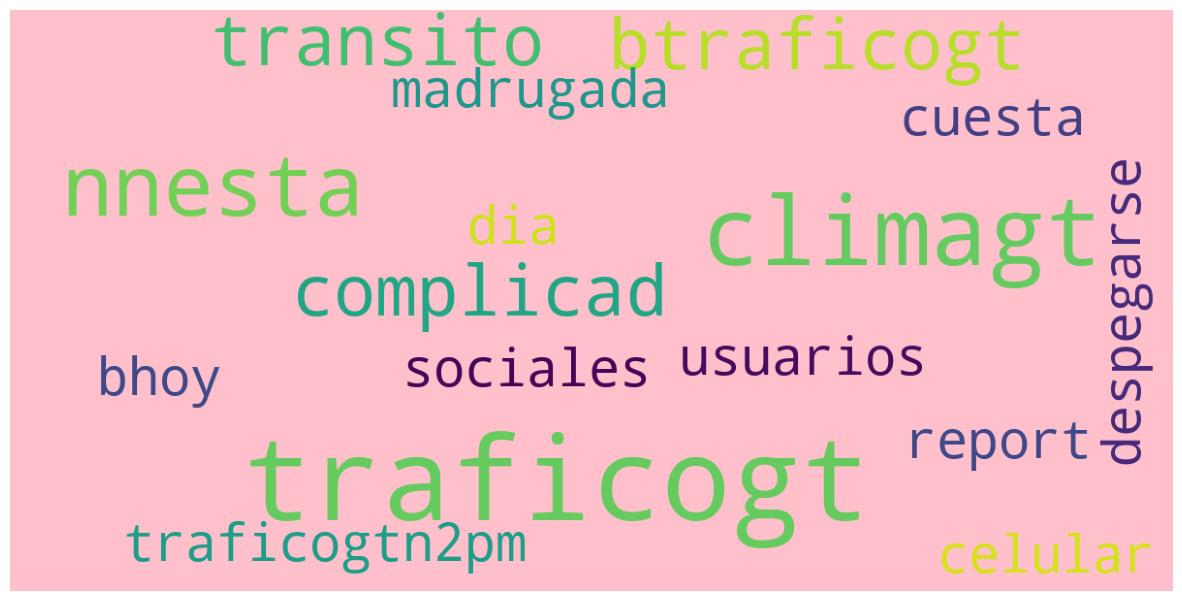

In [11]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt

wordcloud = WordCloud(
        background_color='pink',
        stopwords=stopwords,
        max_words=100,
        max_font_size=40, 
        scale=3,
        random_state=1).generate(str(data['Tweet']))
fig = plt.figure(1, figsize=(15, 15))
plt.axis('off')
plt.imshow(wordcloud)
plt.show()

In [12]:
from collections import Counter
tweet_count = Counter()
splitted_tweets = []
for tweet in data['Tweet']:
    word_list = []
    for word in tweet.split():
        if word not in stopwords:
            word_list.append(word)
    splitted_tweets.append(' '.join(word_list))
for tweet in splitted_tweets:
    tweet_count.update(word.strip('.,?!"').lower() for word in tweet.split())

In [13]:
tweet_count.most_common(20)

[('traficogt', 718),
 ('btraficogt', 205),
 ('antorchas', 198),
 ('ruta', 149),
 ('antorcha', 142),
 ('guatemala', 123),
 ('san', 120),
 ('transito', 113),
 ('hicimos', 111),
 ('grupoceramica', 108),
 ('bulevar', 101),
 ('complicado', 97),
 ('mixco', 90),
 ('carretera', 88),
 ('obelisco', 88),
 ('derrumbe', 87),
 ('hoy', 83),
 ('historico', 81),
 ('entrada', 79),
 ('salvador', 79)]

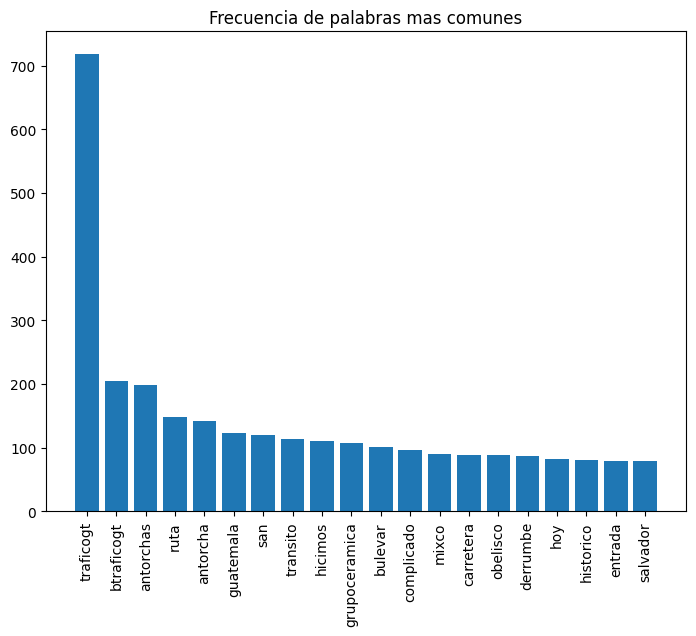

In [14]:
datos_tweet = tweet_count.most_common(20)
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
x_axis = [i[0] for i in datos_tweet]
y_axis = [i[1] for i in datos_tweet]
ax.bar(x_axis,y_axis)
plt.xticks(rotation=90)
plt.title('Frecuencia de palabras mas comunes')
plt.show()

Podemos ver segun la frecuencia de las palabras que en los ultimos dias se repite bastante la palabra antorcha, derrumbe y ciertas areas de la ciudad como mixco y obelisco
lo cual nos indica las areas mas transitadas y ocasiones las cuales hay mas trafico como lo de las antorchas

##Valor sentimental

In [15]:
lexicon = pd.read_table(
            'https://raw.githubusercontent.com/fnielsen/afinn/master/afinn/data/AFINN-en-165.txt',
            names = ['termino', 'sentimiento']
          )
lexicon.head()

,termino,sentimiento
0,abandon,-2
1,abandoned,-2
2,abandons,-2
3,abducted,-2
4,abduction,-2


In [16]:
emotions = []
for tweet in data['Tweet']:
  value = 0
  for word in str(tweet).split(' '):
    x = lexicon.loc[lexicon['termino'] == word]
    if (len(x)>0):
      value += x.sentimiento.iloc[0]
  emotions.append(value)

In [17]:
data = data.assign(positivity_value=emotions)

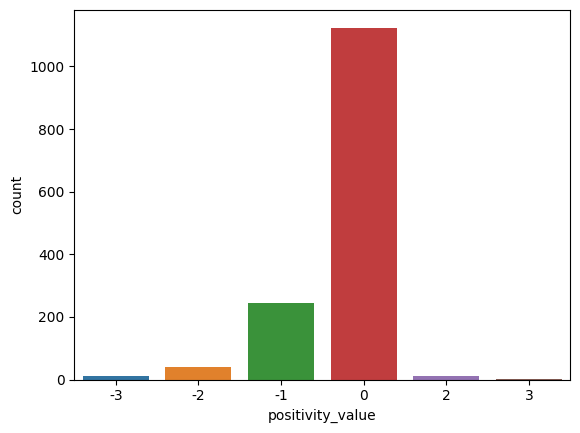

In [18]:
import seaborn as sns
ax = sns.countplot(x="positivity_value",data=data)

In [19]:
positivity_count = pd.value_counts(data.positivity_value).to_frame().reset_index()
positivity_count

,index,positivity_value
0,0,1124
1,-1,243
2,-2,39
3,-3,12
4,2,12
5,3,3


Podemos darnos cuenta que la cantidad de tweet neutros es lo mayoritario, siguiendole los tweets negativos lo cual podriamos esperar.